# Intro
In this chapter, we will fine-tune the pretrained LLM to classify texts.
### Dataset

Overview of fine-tuning process


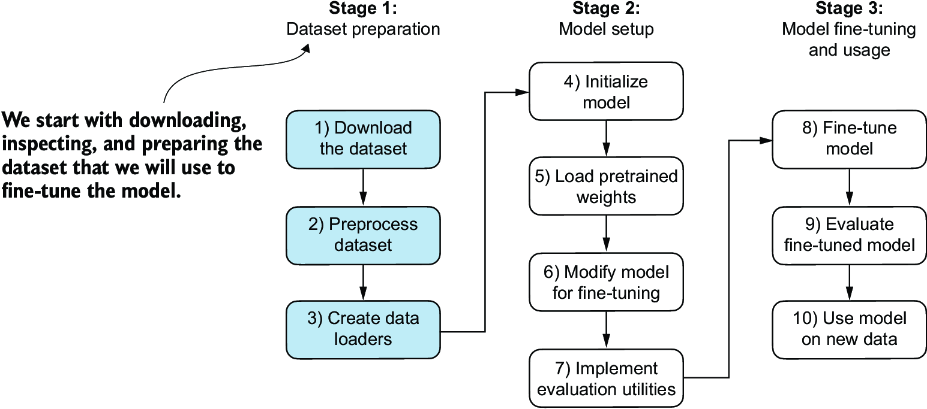

In [36]:
from IPython.display import Image
from termcolor import colored
print(colored("Overview of fine-tuning process", "green", attrs=["bold"]))
Image("images/content.png", width=640*0.8, height=480*0.8)

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists, skipping downloading and extracting")
        return

    with urllib.request.urlopen(url) as response:
        with open(zip_path, 'wb') as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [4]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["label", "text"])
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
print(df["label"].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [6]:
def create_balanced_dataset(df):
    num_spam = df[df["label"]=="spam"].shape[0]
    ham_subset = df[df["label"]=="ham"].sample(num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df["label"]=="spam"]])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["label"].value_counts())

label
ham     747
spam    747
Name: count, dtype: int64


In [7]:
balanced_df["label"] = balanced_df["label"].map({"ham":0, "spam":1})

In [8]:
def random_split(df, train_frac, validation_frac):

    """split the dataset into three parts: 70% for training, 10% for validation, and 20% for testing"""

    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, train_frac=0.7, validation_frac=0.1)

In [9]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### Creating dataloaders

We will develop PyTorch data loaders conceptually similar to those we implemented while working with text data. Previously, we utilized a sliding window technique to generate uniformly sized text chunks, which we then grouped into batches for more efficient model training. Each chunk functioned as an individual training instance. However, we are now working with a spam dataset that contains text messages of varying lengths. To batch these messages as we did with the text chunks, we have two primary options:

Truncate all messages to the length of the shortest message in the dataset or batch.
Pad all messages to the length of the longest message in the dataset or batch.
The first option is computationally cheaper, but it may result in significant information loss if shorter messages are much smaller than the average or longest messages, potentially reducing model performance. So, we opt for the second option, which preserves the entire content of all messages.

To implement batching, where all messages are padded to the length of the longest message in the dataset, we add padding tokens to all shorter messages. For this purpose, we use "**<|endoftext|>**" as a padding token.

In [13]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

/Users/hulkiciray/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[50256]


In [14]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["text"]]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

        self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["label"]
        return (torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long))

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [15]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    tokenizer=tokenizer,
    max_length=None
)

In [20]:
print(train_dataset.max_length)

120


In [21]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    tokenizer=tokenizer,
    max_length=val_dataset.max_length
)

In [26]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers, # (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the process. (default: 0)
    drop_last=True # the drop_last argument drops the last non-full batch of each worker’s dataset replica.
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers, drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers, drop_last=False
)

**To ensure that the data loaders are working and are, indeed, returning batches of the expected size, we iterate over the training loader and then print the tensor dimensions of the last batch:**

In [25]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Target batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Target batch dimensions: torch.Size([8])


In [27]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


**Now that we’ve prepared the data, we need to prepare the model for fine-tuning.**

### Initializing pretrained model
To begin the model preparation process, we employ the same configurations we used to pretrain unlabeled data:

In [38]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "target_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [70]:
import sys
sys.path.append("..")

from ch5.gpt_download import download_and_load_gpt2
from ch4.ch4_02 import GPTModel
from ch5.ch5_02 import load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 26.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 1.04MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 32.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [04:06<00:00, 2.02MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.99MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 665kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 627kiB/s] 


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [67]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [71]:
from ch5.ch5_02 import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you.





.









In [72]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' Answer a cash award a cash award cash' cash cash cash a cash a cash' cash a cash' cash'


**Based on the output, it’s apparent that the model is struggling to follow instructions.**
Let's prepare the model for classification fine-tuning.

### Adding Classification Head

We must modify the pretrained LLM to prepare it for classification fine-tuning. To do so, we replace the original output layer, which maps the hidden representation to a vocabulary of 50,257, with a smaller output layer that maps to two classes: 0 (“not spam”) and 1 (“spam”), as shown in figure below.

Image below represents adding classification head onto our model. Detailed explanation is located above.


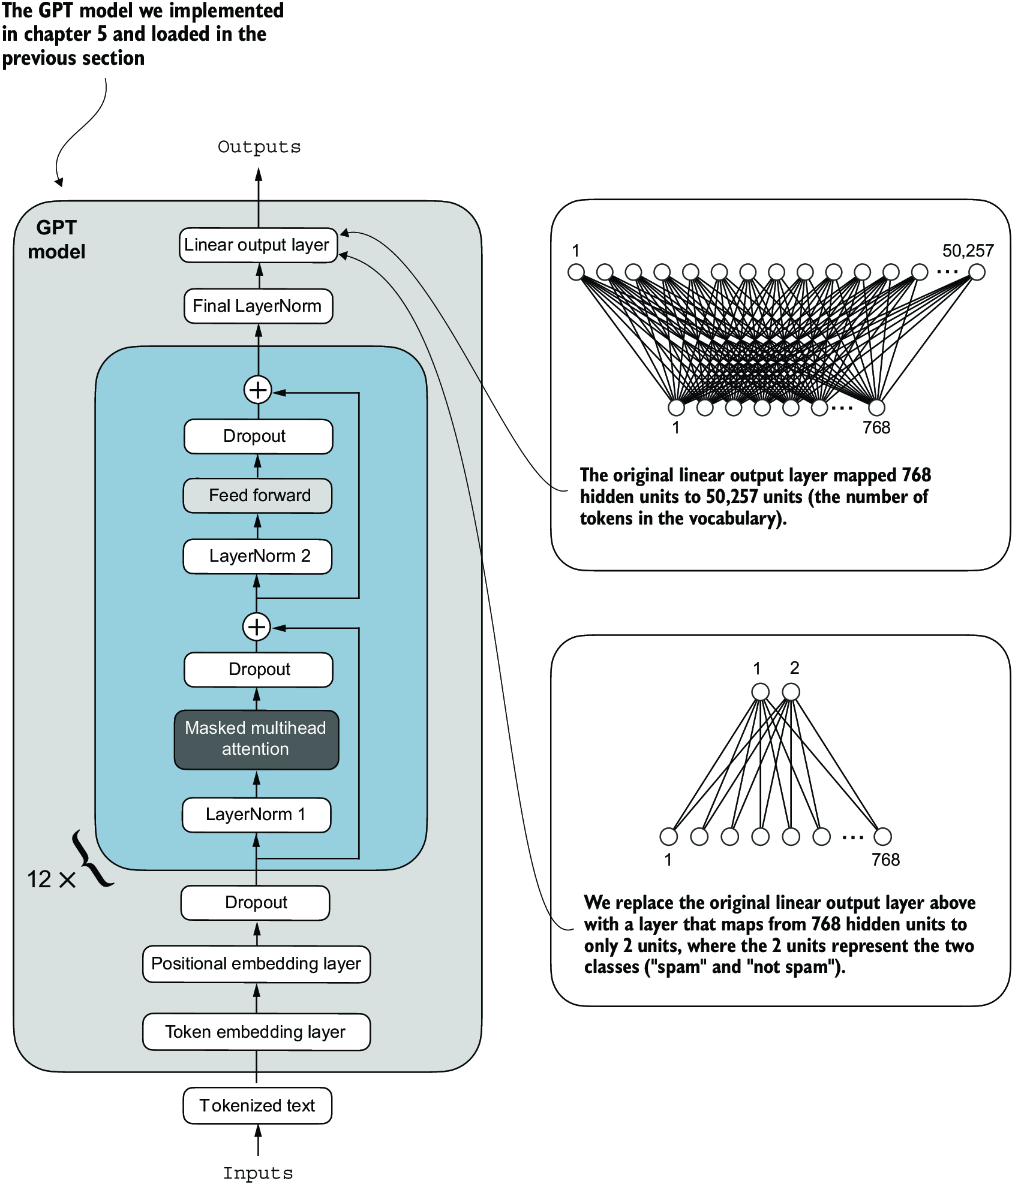

In [80]:
print(colored("Image below represents adding classification head onto our model. Detailed explanation is located above.",
              "light_yellow",
              attrs=["bold"]))
Image("images/classification-head.png", width=640*1.6, height=480*1.6)

In [81]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

The model has embedding layers and 12 transformer blocks followed by a final `LayerNorm` and the output layer, `out_head`

Next, we replace the `out_head` with a new output layer (see figure above) that we will fine-tune.

To get the model ready for classification fine-tuning, we first **freeze the model**, meaning that we **make all layers nontrainable.**

In [82]:
for param in model.parameters():
    param.requires_grad = False

In [83]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

This new `model.out_head` output layer has its `requires_grad` attribute set to True by default, which means that it’s the only layer in the model that will be updated during training.

We also **configure the last `transformer` block** and the **final `LayerNorm`** module, which connects this block to the output layer, to be **trainable**

In [84]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [85]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs: ", inputs)
print("Inputs dimension: ", inputs.shape)

Inputs:  tensor([[5211,  345,  423,  640]])
Inputs dimension:  torch.Size([1, 4])


In [86]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs: \n", outputs)
print("Outputs dimension: ", outputs.shape)

Outputs: 
 tensor([[[-0.5966,  0.6271],
         [-2.8117,  6.8164],
         [-2.0197,  5.6612],
         [-3.3210,  4.7156]]])
Outputs dimension:  torch.Size([1, 4, 2])


The GPT model with a four-token example input and output. The output tensor consists of two columns due to the modified output layer. We are only interested in the last row corresponding to the last token when fine-tuning the model for spam classification.


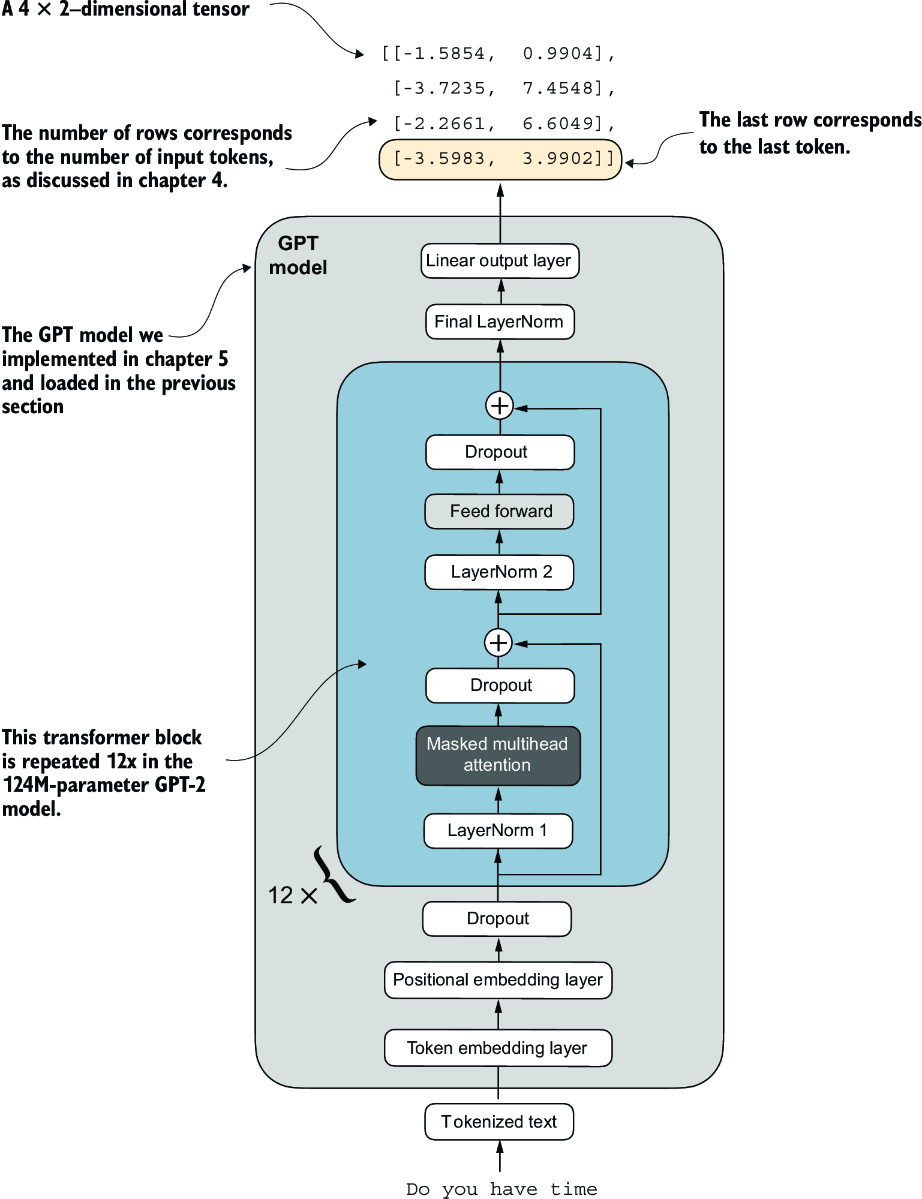

In [91]:
print(colored("The GPT model with a four-token example input and output. The output tensor consists of two columns due to the modified output layer. We are only interested in the last row corresponding to the last token when fine-tuning the model for spam classification.",
              "light_yellow",
              attrs=["bold"]))
Image("images/example-output.png", width=640*2, height=480*1.6)

In [92]:
print("Last output token: ", outputs[:, -1, :])

Last output token:  tensor([[-3.3210,  4.7156]])


The reason why we focus on the last output token only is because in the causal attention mechanism, the last token has the most information about the current and the previous tokens. And it has the most number of tokens before itself.

Let's transform the last token into class label predictions to calculate the model's initial prediction accuracy.

### Clasification Loss and Accuracy

Last step is to implement the model evaluation functions.

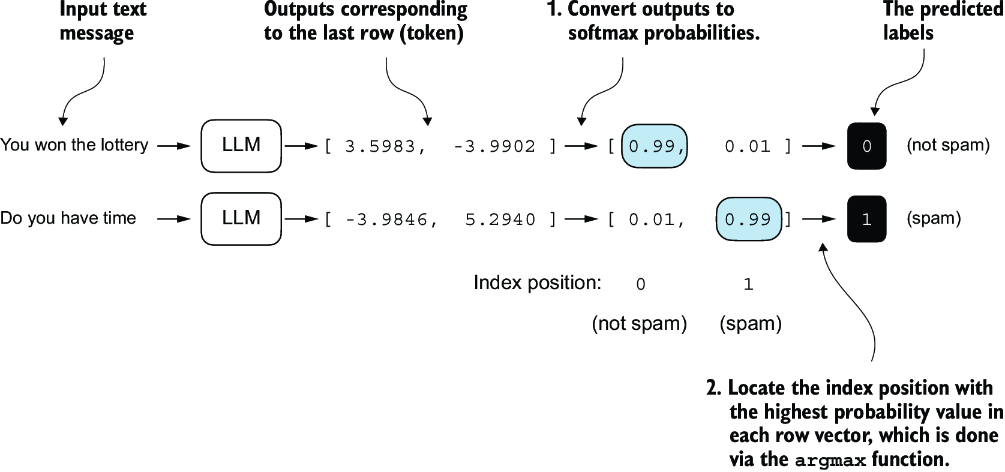

In [96]:
Image("images/loss calculation visual.png", width=640*1, height=480*1)

In [97]:
print("Last output toke:", outputs[:, -1, :])

Last output toke: tensor([[-3.3210,  4.7156]])


In [135]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)

print("probas: ", probas)
print("label: ", label)
print("Class label:", label.item())

probas:  tensor([[3.2331e-04, 9.9968e-01]])
label:  tensor(1)
Class label: 1


In this case, the code returns 1, meaning the model predicts that the input text is “spam.” Using the `softmax function here is optional` because the largest outputs directly correspond to the highest probability scores. Hence, we can simplify the code `without using softmax`

In [133]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("logits:", logits)
print("label:", label)
print("Class label:", label.item())

logits: tensor([[-3.3210,  4.7156]])
label: tensor(1)
Class label: 1


In [110]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")

To determine the classification accuracy, we apply the argmax-based prediction code to all examples in the dataset and calculate the proportion of correct predictions by defining a `calc_accuracy_loader` function.

In [111]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]

            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )
        else:
            break
    return correct_predictions / num_examples


In [112]:
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Val accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Train accuracy: 51.25%
Val accuracy: 47.50%
Test accuracy: 57.50%


As we can see, the prediction accuracies are near a random prediction, which would be 50% in this case. **To improve the prediction accuracies, we need to fine-tune the model.**

In [114]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

We use the calc_loss_batch function to compute the loss for a single batch obtained from the previously defined data loaders. To calculate the loss for all batches in a data loader, we define the calc_loss_loader function as before.

In [115]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [116]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 1.349
Validation loss: 2.469
Test loss: 3.409


Next, we will implement a training function to fine-tune the model, which means adjusting the model to minimize the training set loss. Minimizing the training set loss will help increase the classification accuracy, which is our overall goal.

### Fine-tuning the Model

This is typical training loop of pytorch


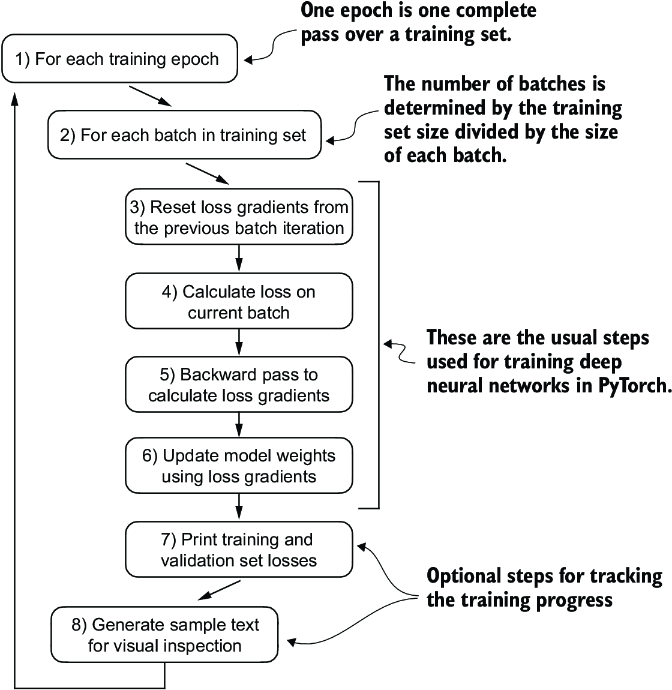

In [121]:
print(colored("This is typical training loop of pytorch", "green", attrs=["bold"]))
Image("images/training loop.png", width=640*1.4, height=480*1.4)

In [122]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss: {train_loss:.3f} "
                      f"Val loss: {val_loss:.3f}"
                )
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")

        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [123]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()
    return train_loss, val_loss

In [125]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in: {execution_time_minutes:.2f}minutes")

Ep 1 (Step 000000): Train loss: 1.069 Val loss: 2.120
Ep 1 (Step 000050): Train loss: 0.432 Val loss: 0.477
Ep 1 (Step 000100): Train loss: 0.199 Val loss: 0.424
Training accuracy: 90.00% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss: 0.279 Val loss: 0.254
Ep 2 (Step 000200): Train loss: 0.119 Val loss: 0.221
Ep 2 (Step 000250): Train loss: 0.122 Val loss: 0.297
Training accuracy: 90.00% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss: 0.081 Val loss: 0.303
Ep 3 (Step 000350): Train loss: 0.127 Val loss: 0.133
Training accuracy: 95.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss: 0.076 Val loss: 0.130
Ep 4 (Step 000450): Train loss: 0.083 Val loss: 0.173
Ep 4 (Step 000500): Train loss: 0.160 Val loss: 0.170
Training accuracy: 97.50% | Validation accuracy: 92.50%
Ep 5 (Step 000550): Train loss: 0.061 Val loss: 0.143
Ep 5 (Step 000600): Train loss: 0.045 Val loss: 0.226
Training accuracy: 100.00% | Validation accuracy: 95.00%
Training complete

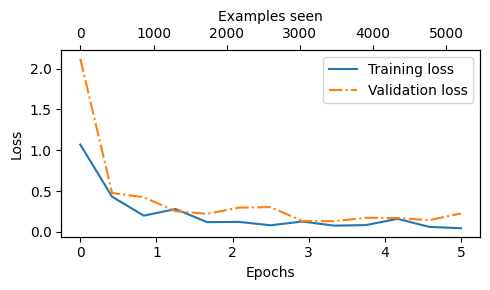

In [126]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))


    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()


    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

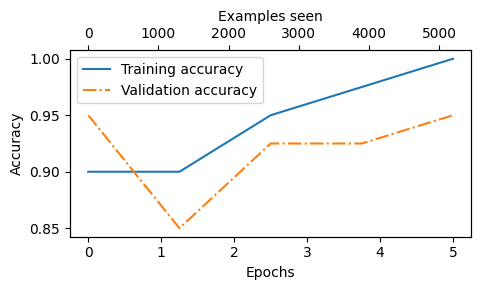

In [128]:
epoch_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epoch_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")


In [129]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.23%
Validation accuracy: 97.32%
Test accuracy: 95.00%


### Using the LLM as a Spam Classifier

Now we are on the last part. Let's try the model with sample mails...


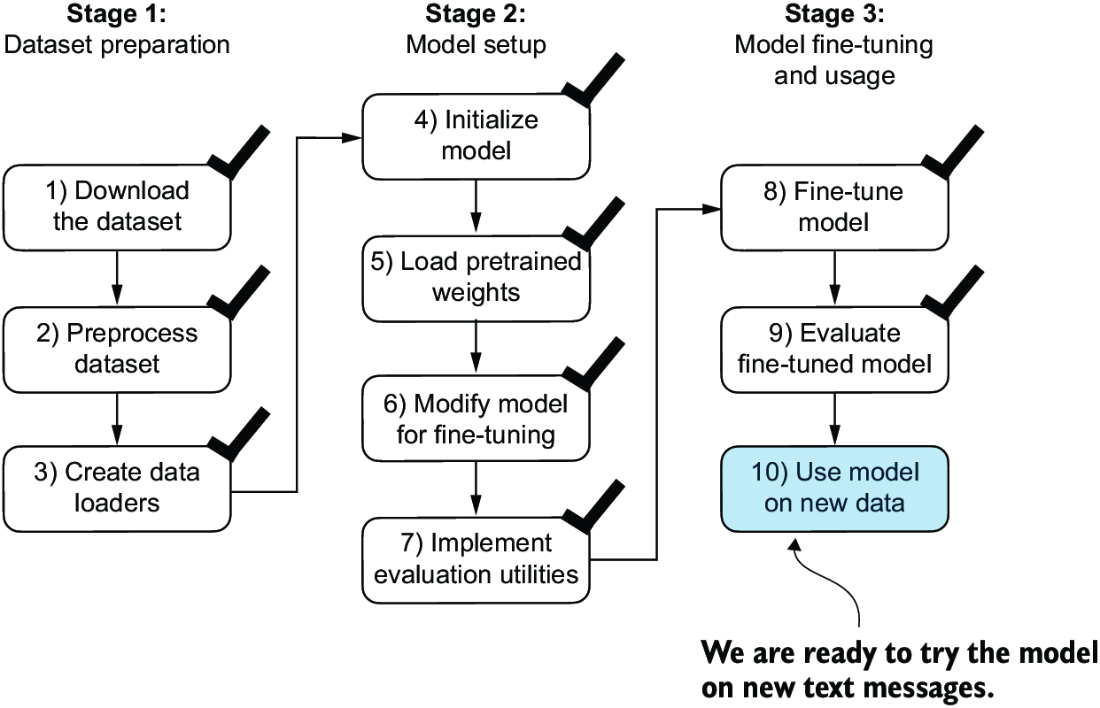

In [150]:
print(colored("Now we are on the last part. Let's try the model with sample mails...", "light_cyan", attrs=["bold"]))
Image("images/last step.png", width=640*1.2, height=480*1.2)

In [151]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]
    input_ids = input_ids[: min(supported_context_length, max_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [152]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award"
)

print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [154]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


**Finally, let’s save the model in case we want to reuse the model later without having to train it again. We can use the `torch.save` method:**

In [155]:
torch.save(model.state_dict(), "review_classifier.pth")

**The saved model can be loaded as follows:**

In [157]:
model_state_dict = torch.load("review_classifier.pth", map_location = device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

### Summary
- There are different strategies for fine-tuning LLMs, including classification fine-tuning and instruction fine-tuning.
- Classification fine-tuning involves replacing the output layer of an LLM via a small classification layer.
- In the case of classifying text messages as "spam" or "not spam", the new classification layer consists of only 2 output nodes. Previously we used the number of output nodes equal to the number of unique tokens in the vocabulary.
- Instead of predicting the next token in the text as in pretraining, classification fine-tuning trains the model to output a correct class label -for example "spam" or "not spam".
- The model input for fine-tuning is text converted into token IDs similar to pretraining.
- Before fine-tuning an LLM, we load the pretrained model as a base model.
- Evaluating a classification model involves calculating the classification accuracy (the fraction or percentage of correct predictions).
- Fine-tuning a classification model uses the same cross-entropy loss function as when pretraining the LLM.